In [37]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the athlete clears the bar with an arched back
def is_arching_back(shoulder, hip, spine):
    """
    Determines if the athlete is arching their back by analyzing the relative positions
    of the shoulder, hip, and spine keypoints.
    The back is considered arched if the spine is lower than the shoulder and hip.
    """
    shoulder_x, shoulder_y = shoulder
    hip_x, hip_y = hip
    spine_x, spine_y = spine

    # Arching condition: spine should be lower than both shoulder and hip
    return spine_y > hip_y and spine_y > shoulder_y

# Paths for the stage 4 videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage4/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage4/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for back arch analysis
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                left_spine = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,  # Approx spine location
                              (landmarks[mp_pose.PoseLandmark.LEFT_HIP].y + landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y) / 2]

                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
                right_spine = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                               (landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y + landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y) / 2]

                # Check if the athlete is arching their back for both sides
                left_arch = is_arching_back(left_shoulder, left_hip, left_spine)
                right_arch = is_arching_back(right_shoulder, right_hip, right_spine)

                # Store data for this frame
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "left_arch": left_arch,
                    "right_arch": right_arch,
                    "left_shoulder": left_shoulder,
                    "left_hip": left_hip,
                    "left_spine": left_spine,
                    "right_shoulder": right_shoulder,
                    "right_hip": right_hip,
                    "right_spine": right_spine
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Back arch analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737666891.788539 11169161 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737666891.849397 11393032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737666891.861894 11393036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Back arch analysis complete! JSON files saved in 'keypoints' folder.


In [39]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for arched back analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage4/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract back arch indicators across all frames
        arch_data = [
            [int(frame["left_arch"]), int(frame["right_arch"])]
            for frame in data
        ]
        sequences.append(arch_data)

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [40]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 57, Validation samples: 18


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [43]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.3174 - mae: 0.3339 - val_loss: 0.3045 - val_mae: 0.3723
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2452 - mae: 0.2909 - val_loss: 0.2855 - val_mae: 0.3802
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2293 - mae: 0.3041 - val_loss: 0.2632 - val_mae: 0.3902
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2081 - mae: 0.3203 - val_loss: 0.2414 - val_mae: 0.4029
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1551 - mae: 0.3122 - val_loss: 0.2242 - val_mae: 0.4150
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1871 - mae: 0.3738 - val_loss: 0.2083 - val_mae: 0.4158
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1665 - mae: 0.3741 - val_loss: 0.2012 - val_mae: 0.4097
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1665 - mae: 0.3718 - val_loss: 0.2062 - val_mae: 0.4007
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1

In [44]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.2236, Validation MAE: 0.3821


In [45]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Predicted: 0.21, Actual: 0.00
Predicted: 0.20, Actual: 0.50
Predicted: 0.21, Actual: 0.00
Predicted: 0.21, Actual: 0.00
Predicted: 0.21, Actual: 1.00
Predicted: 0.21, Actual: 0.50
Predicted: 0.07, Actual: 0.00
Predicted: 0.00, Actual: 0.00
Predicted: 0.21, Actual: 1.00
Predicted: 0.21, Actual: 0.50
Predicted: 0.21, Actual: 0.00
Predicted: 0.43, Actual: 0.00
Predicted: 0.21, Actual: 1.00
Predicted: 0.19, Actual: 0.00
Predicted: 0.21, Actual: 1.00
Predicted: 0.52, Actual: 0.00
Predicted: 0.21, Actual: 1.00
Predicted: 0.02, Actual: 0.00


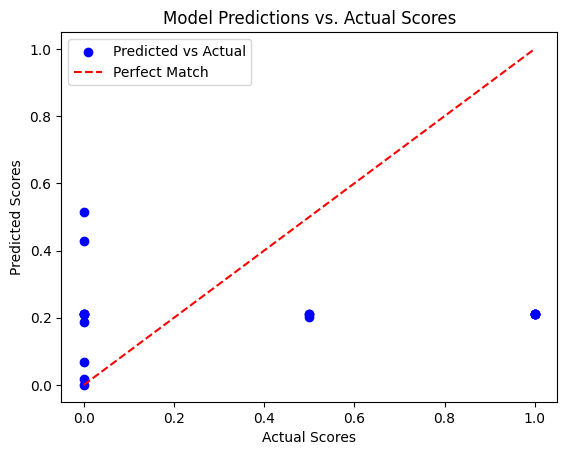

In [46]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [47]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the athlete clears the bar with an arched back
def is_arched_back(shoulder, hip, back_mid):
    """
    Determines if the athlete clears the bar with an arched back by analyzing
    the curvature of the back (shoulder, hip, and midpoint of the back).
    Conditions:
    - The back midpoint should be lower (y-axis) than the shoulder and hip.
    - Shoulder and hip should maintain a horizontal distance.
    """
    shoulder_x, shoulder_y = shoulder
    hip_x, hip_y = hip
    back_mid_x, back_mid_y = back_mid

    arched_back = back_mid_y > shoulder_y and back_mid_y > hip_y
    return arched_back

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage4/test_videos/1_user12.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for arched back analysis
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        left_back_mid = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                         (landmarks[mp_pose.PoseLandmark.LEFT_HIP].y + landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y) / 2]

        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        right_back_mid = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                          (landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y + landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y) / 2]

        # Check for arched back posture
        left_arch = is_arched_back(left_shoulder, left_hip, left_back_mid)
        right_arch = is_arched_back(right_shoulder, right_hip, right_back_mid)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_arch), int(right_arch)])

cap.release()

# Pad the sequence to match training input length
max_seq_length = X_train.shape[1]  # Ensure it's the same length used during training
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 2))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737667390.517699 11169161 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737667390.575106 11548614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737667390.586222 11548620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Predicted Score: 0.21


In [48]:
print(X_train.shape[1])

84


In [49]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.8:
        return 1.0
    elif prediction >= 0.6:
        return 0.5
    else:
        return 0.0

In [50]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.5
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.5
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.5
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0


In [51]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [52]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [53]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Classification Accuracy: 0.56


In [54]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage4/models/highjump_stage4.keras")